# California House Price Prediction

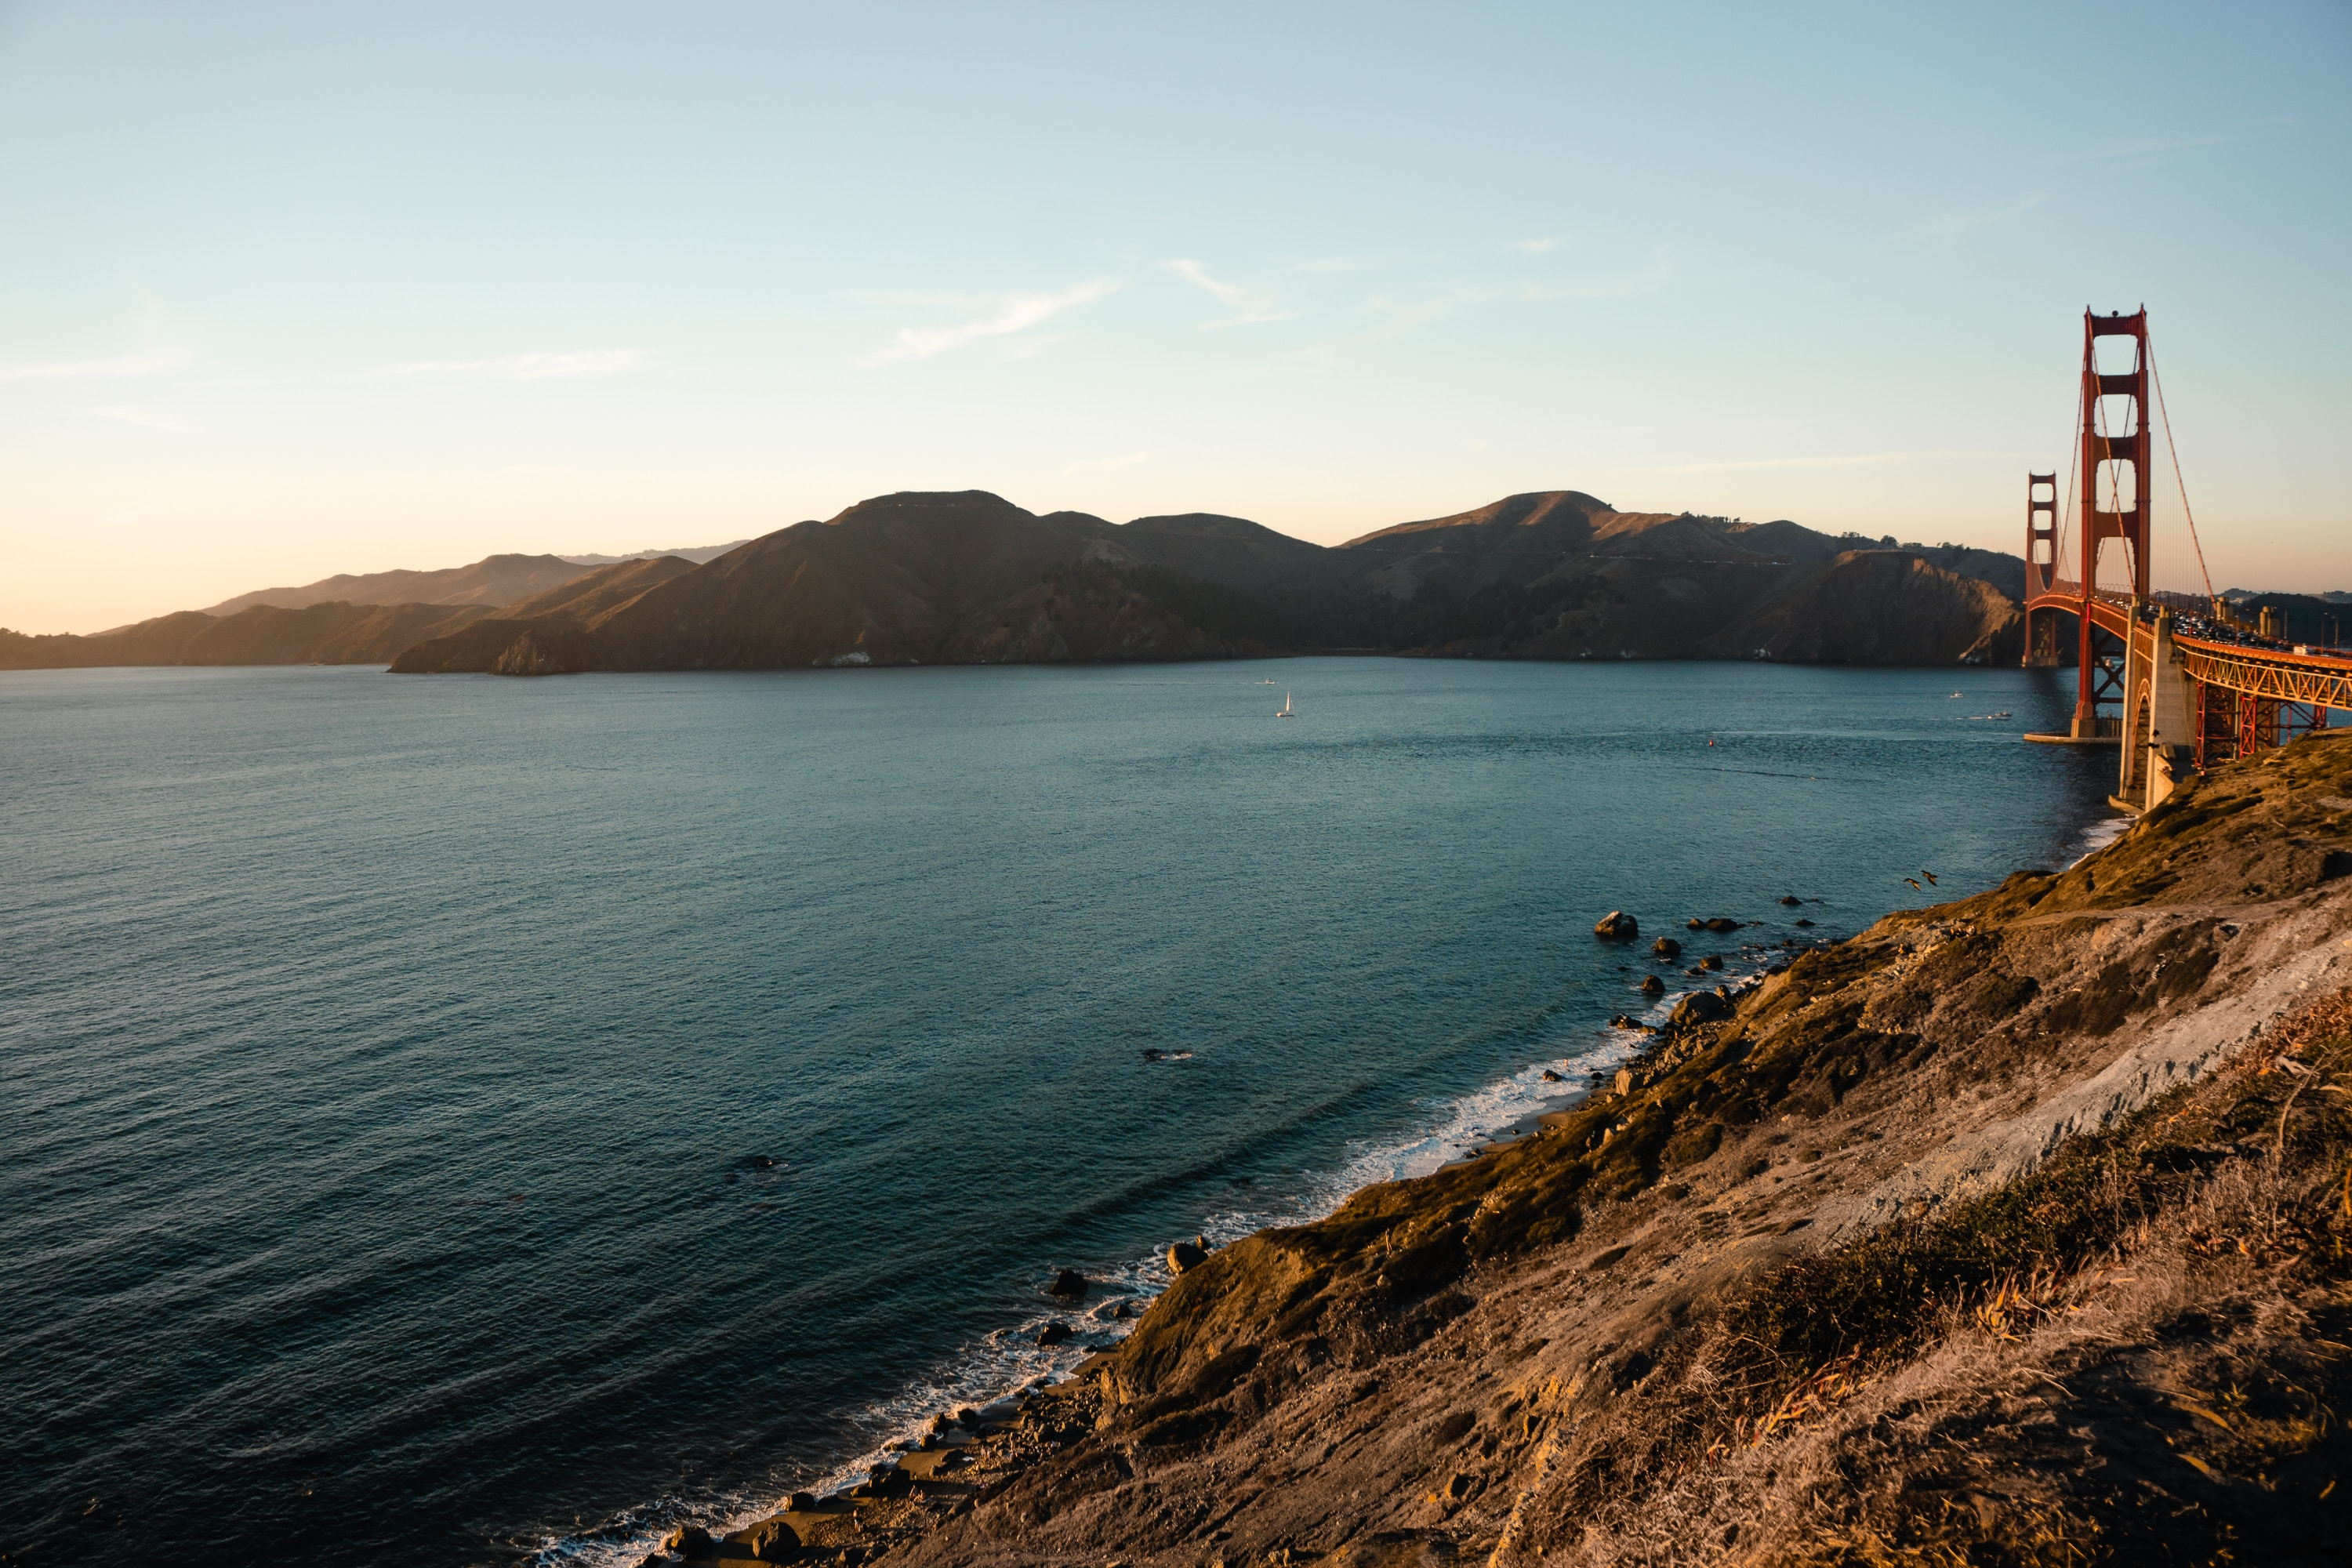

https:// github.com/ageron/handson-ml2.

In [14]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick',labelsize = 12)
mpl.rc('ytick', labelsize = 12)

%matplotlib inline

In [8]:
housing = pd.read_csv('housing.csv')

In [9]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20640 instances in the dataset. However, total_bedrooms contains only 20433 instances the rest are null values. All the features/attributes are numeric in nature except for ocean_proximity which is a python object. Nevertheless, since we loaded the data from a csv file, the object must be a text attribute. From the first 5 rows of the data we can see that the values in the ocean_proximity attribute are repeating. 

In [11]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
housing.describe() # describe() gives a summary of all the numeric fields

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


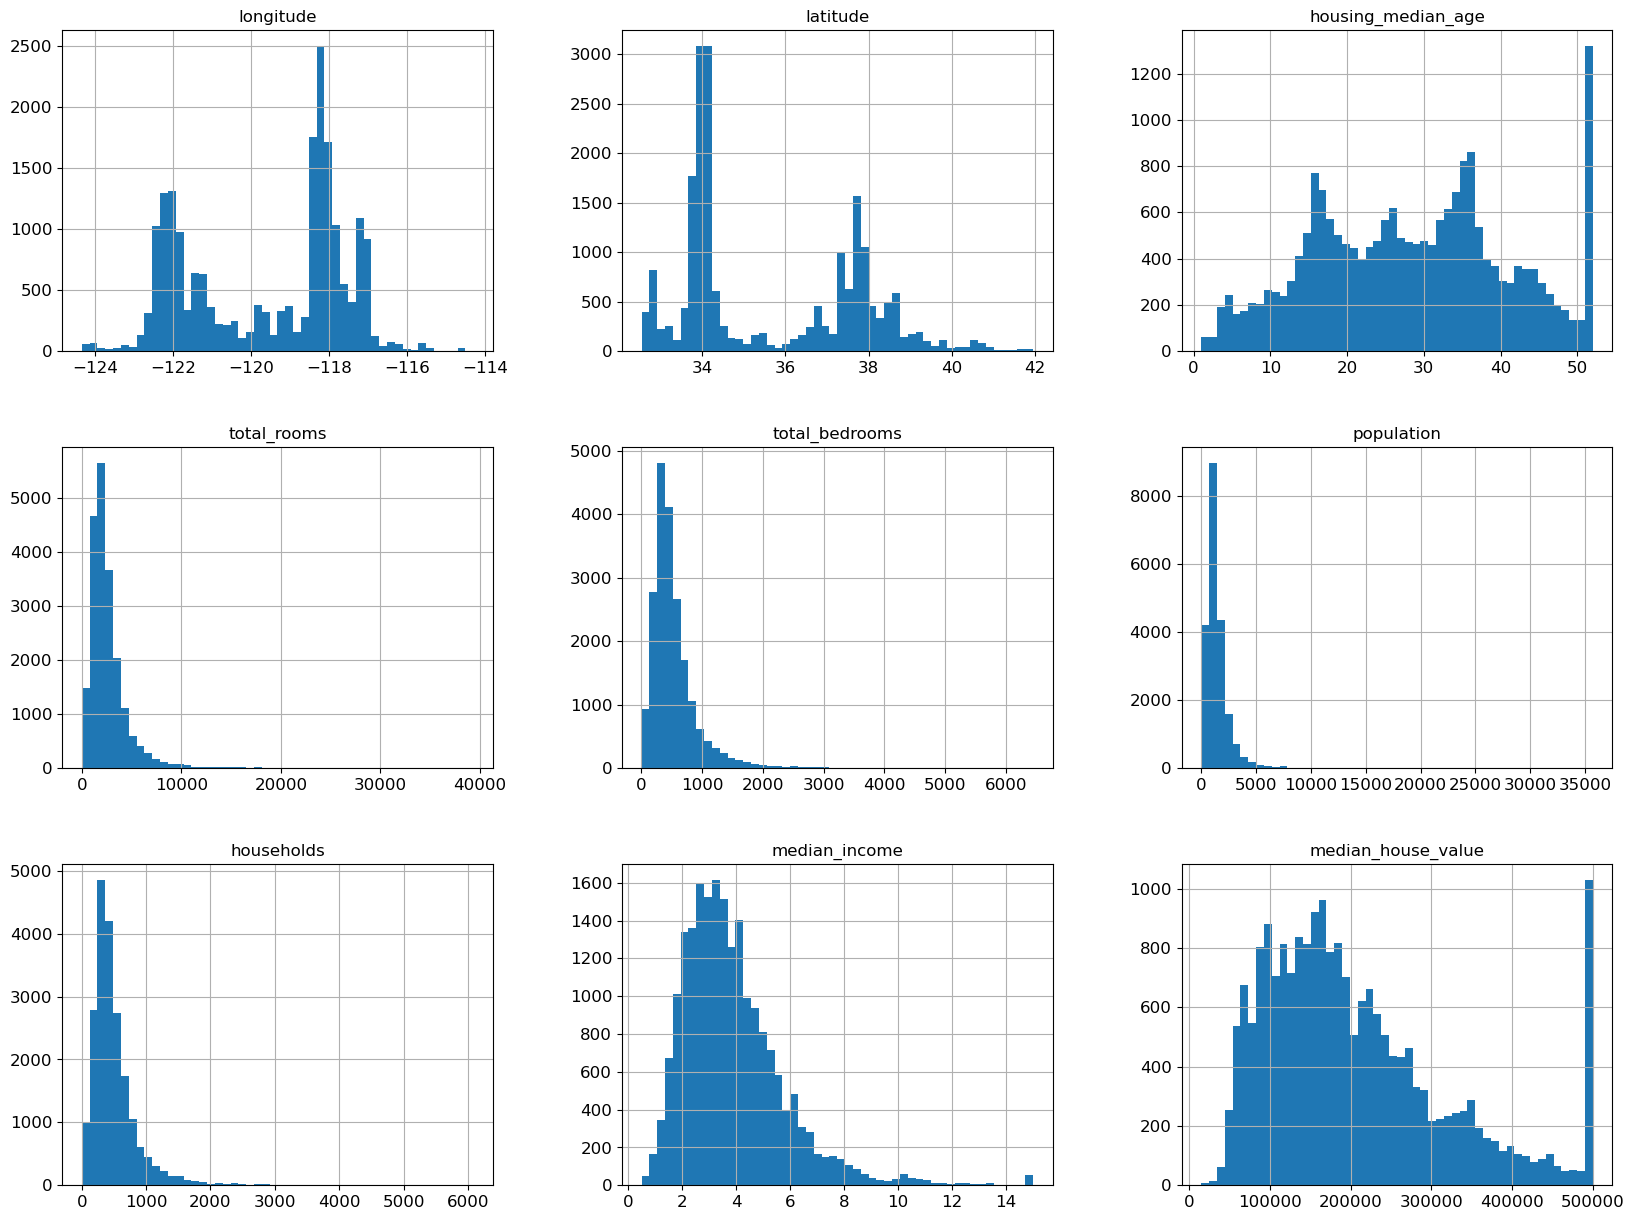

In [15]:
housing.hist(bins = 50, figsize = (20,15))
plt.show()

1. The median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about USD 30,000). 
2. The housing median age and the median house value were also capped. The lat‐ ter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s out‐ put) to see if this is a problem or not. If they tell you that they need precise pre‐ dictions even beyond USD 500,000, then you have mainly two options:<br>
    a. Collect proper labels for the districts whose labels were capped.<br>
    b. Remove those districts from the training set (and also from the test set, since your system should not be    evaluated poorly if it predicts values beyond USD 500,000).<br>
3. These attributes have very different scales. We will discuss this later in this chap‐ ter when we explore feature scaling.<br>
4. Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

# Creating a Test Set
It may sound strange to voluntarily set aside part of the data at this stage. After all, you have only taken a quick glance at the data, and surely you should learn a whole lot more about it before you decide what algorithms to use, right? This is true, but your brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of Machine Learning model. When you estimate the generalization error using the test set, your estimate will be too optimistic and you will launch a system that will not perform as well as expected. This is called data snooping bias.

In [16]:
# for the output of this notebook to be constant every time it is run
np.random.seed(42)

In [19]:
# defining our own train-test-split
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio) 
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [22]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


A common solution to stop the machine from seeing the entire dataset is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set. Here is a possible implementation:

In [27]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [28]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [29]:
housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [30]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [32]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,-122212.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY,-122232.15
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY,-122232.16


Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split, which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features. First there is a random_state parameter that allows you to set the random generator seed as explained previously, and second you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices 

In [33]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state = 42)

In [34]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant <b>sampling bias</b>. 

When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. <b>This is called strati‐ fied sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.</b> 

If they used purely random sampling, there would be about 12% chance of sampling a skewed test set with either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased.

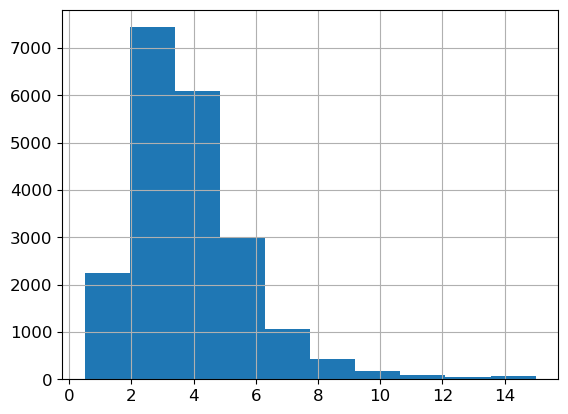

In [36]:
housing.median_income.hist();

Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. 

Let’s look at the median income histogram more closely: most median income values are clustered around 1.5 to 6 (i.e., USD 15,000–USD 60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. 

The following code uses the pd.cut() function to create an income category attribute with 5 categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than USD 15,000), category 2 from 1.5 to 3, and so on:

In [37]:
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf], 
                               labels = [1,2,3,4,5])

In [38]:
housing.income_cat.value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

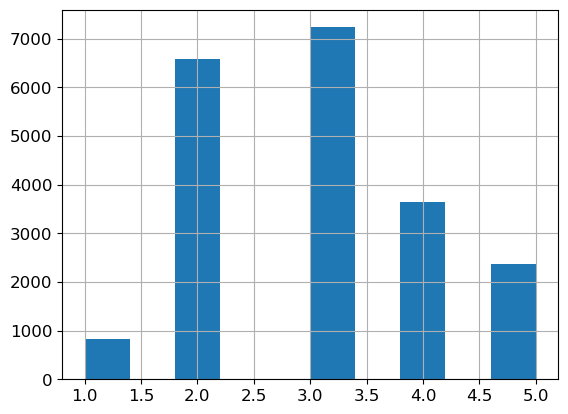

In [40]:
housing.income_cat.hist();

Performing Stratified sampling based on income category

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit 

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let’s see if this worked as expected. You can start by looking at the income category proportions in the test set:

In [43]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [48]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts()/len(data)

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

compare_props = pd.DataFrame({
    'Overall': income_cat_proportions(housing),
    'Stratified': income_cat_proportions(strat_test_set),
    'Random': income_cat_proportions(test_set),
}).sort_index()

compare_props['Rand. %error'] = 100 * compare_props['Random']/compare_props['Overall'] - 100
compare_props['Strat. %error'] = 100 * compare_props['Stratified']/compare_props['Overall'] - 100

In [49]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


The DataFrame above compares the income category proportions in the overall dataset, in the test set generated with stratified sampling, and in a test set generated using purely random sampling. 

<b>The test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is quite skewed.</b>

Now you should remove the income_cat attribute so the data is back to its original state:

In [50]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis = 1, inplace = True)

# Data Exploration and Visualization

First, make sure you have put the test set aside and you are only exploring the train‐ ing set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so you can just work directly on the full set. Let’s create a copy so you can play with it without harming the training set:

In [51]:
housing = strat_train_set.copy()

In [53]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [54]:
housing.corr()

/var/folders/kd/vczjh0f55158sc6lflbyfd4w0000gn/T/ipykernel_6206/1598269145.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  housing.corr()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


The median_house_value depends on the median_income and to an extend on total_rooms and housing_median_age. As expected population attribute is closely related to households, total_rooms and total_bedrooms. Median_income is sparsely related to total_rooms.

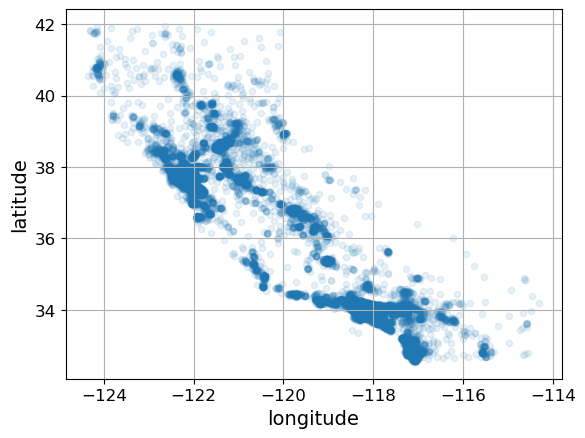

In [59]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)
plt.grid(True);

This looks like California all right, but other than that it is hard to see any particular pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points.

You can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet.

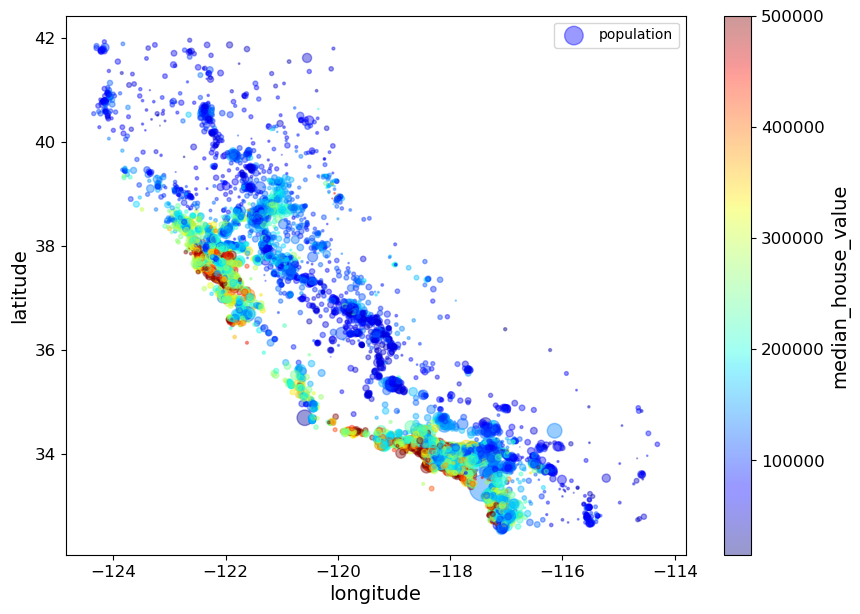

In [61]:
housing.plot(kind = 'scatter',  x = 'longitude', y = 'latitude', alpha = 0.4, 
            s = housing['population']/100, label = 'population', figsize = (10,7),
            c = 'median_house_value', cmap = plt.get_cmap('jet'), colorbar = True);

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean prox‐ imity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

In [65]:
corr_matrix = housing.corr()['median_house_value'].sort_values(ascending = False)
corr_matrix

/var/folders/kd/vczjh0f55158sc6lflbyfd4w0000gn/T/ipykernel_6206/979393521.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()['median_house_value'].sort_values(ascending = False)


median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to zero mean that there is no linear correlation.

The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to zero then y gen‐ erally goes up”).

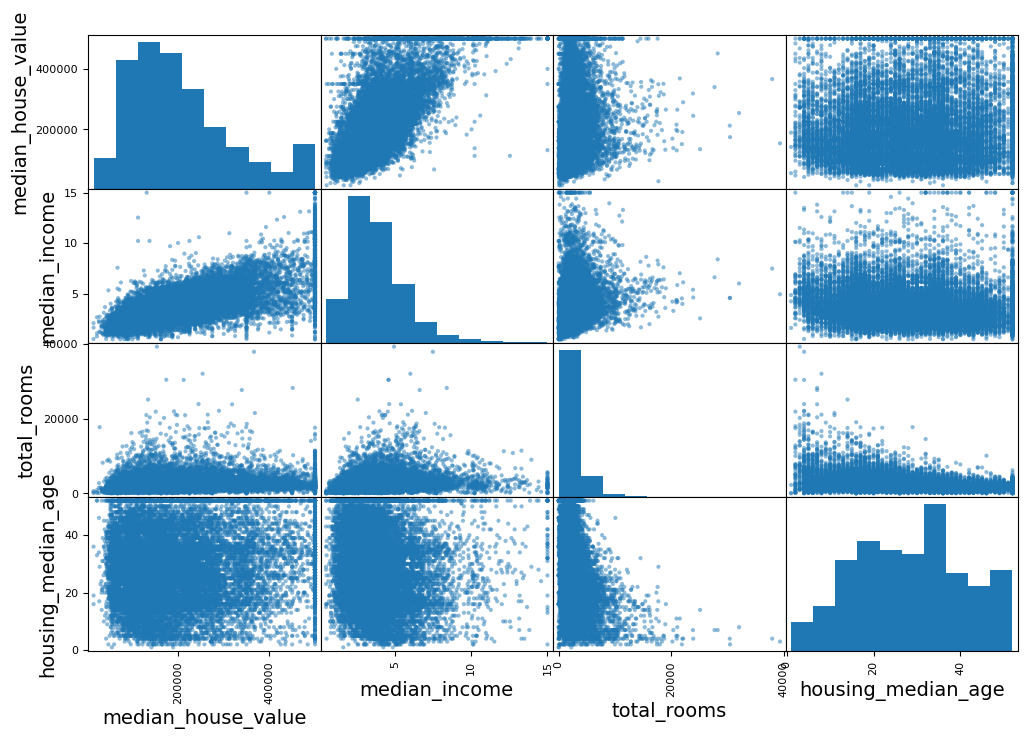

In [68]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value','median_income', 'total_rooms','housing_median_age']
scatter_matrix(housing[attributes], figsize = (12,8));

The main diagonal Pandas displays a histogram of each attribute. The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

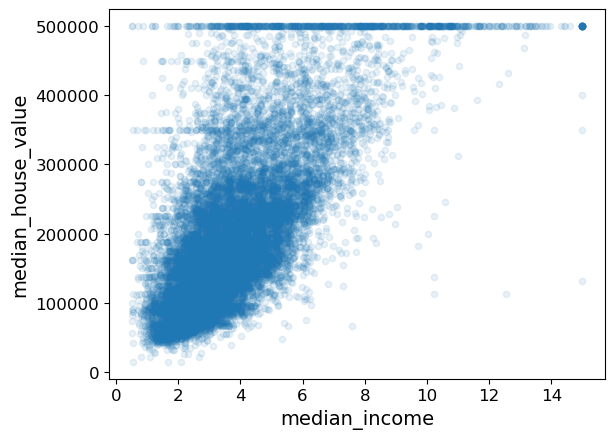

In [70]:
housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at USD 500,000. But this plot reveals other less obvious straight lines: a horizontal line around USD 450,000, another around USD 350,000, perhaps one around $280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

In [71]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [81]:
housing['total_rooms_per_household'] = housing['total_rooms']/housing['households']
housing['total_bedrooms_per_household'] = housing['total_bedrooms']/housing['households']
housing['total_population_per_household'] = housing['population']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']

In [82]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_rooms_per_household,total_bedrooms_per_household,total_population_per_household,bedrooms_per_room
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,1.128895,3.168555,0.205784
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,1.113281,2.623698,0.160714
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,1.033333,2.223333,0.191595
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,1.074534,1.859213,0.276505
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,1.113793,3.167241,0.182692


In [83]:
corr_matrix = housing.corr()['median_house_value'].sort_values(ascending = False)
corr_matrix

/var/folders/kd/vczjh0f55158sc6lflbyfd4w0000gn/T/ipykernel_6206/979393521.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()['median_house_value'].sort_values(ascending = False)


median_house_value                1.000000
median_income                     0.687151
total_rooms_per_household         0.146255
total_rooms                       0.135140
housing_median_age                0.114146
households                        0.064590
total_bedrooms                    0.047781
total_population_per_household   -0.021991
population                       -0.026882
total_bedrooms_per_household     -0.043349
longitude                        -0.047466
latitude                         -0.142673
bedrooms_per_room                -0.259952
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. 

<b>This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first rea‐ sonably good prototype. But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.</b>

# Prepare Data for Machine Learning Algorithms 

In [85]:
housing = strat_train_set.drop('median_house_value', axis = 1) # dropping labels for training dataset
housing_labels = strat_train_set['median_house_value'].copy()

## Data Cleaning
Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. You noticed earlier that the total_bedrooms attribute has some missing values, so let’s fix this. 
You have three options:<br>
• Get rid of the corresponding districts.<br>
• Get rid of the whole attribute.<br>
• Set the values to some value (zero, the mean, the median, etc.).<br>
You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna() methods:

In [87]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [88]:
sample_incomplete_rows.dropna(subset=['total_bedrooms']) # option1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [89]:
sample_incomplete_rows.drop('total_bedrooms', axis = 1) # option2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [91]:
median_total_bedrooms = housing['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median_total_bedrooms, inplace = True) # option 3

In [92]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


Don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

In [93]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity:

In [95]:
housing_num = housing.drop('ocean_proximity', axis = 1)

Now you can fit the imputer instance to the training data using the fit() method:

In [96]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable. Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [97]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [99]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Now you can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

In [100]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If you want to
put it back into a Pandas DataFrame, it’s simple:

In [104]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing.index)

In [105]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [110]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(5)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


Most Machine Learning algorithms prefer to work with numbers anyway, so let’s con‐ vert these categories from text to numbers. For this, we can use Scikit-Learn’s OrdinalEncoder class19:


In [113]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [115]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

You can get the list of categories using the categories_ instance variable. It is a list containing a 1D array of categories for each categorical attribute (in this case, a list containing a single array since there is just one categorical attribute):

In [116]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes. Scikit-Learn provides a OneHotEn coder class to convert categorical values into one-hot vectors20:

In [117]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

In [119]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by calling the toarray() method:

In [121]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Alternatively, you can set sparse=False when creating the OneHotEncoder:

In [122]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species, etc.), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the ocean_proximity feature with the distance to the ocean (similarly, a country code could be replaced with the country’s population and GDP per capita).

Creating a custom transformer to add extra attributes:

In [126]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index 
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y= None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperpara‐ meter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and sav‐ ing you a lot of time).

In [127]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the hous‐ ing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.
There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.
Min-max scaling (many people call this normalization) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtract‐ ing the min value and dividing by the max minus the min. Scikit-Learn provides atransformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if you don’t want 0–1 for some reason.

Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algo‐ rithms (e.g., neural networks often expect an input value ranging from 0 to 1). How‐ ever, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for stand‐ ardization.

## Transformation Pipelines

In [131]:
# Read this part again to understand it

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [129]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method). The names can be anything you like (as long as they are unique and don’t contain double underscores “__”): they will come in handy later for hyperparameter tuning.

When you call the pipeline’s fit() method, it calls fit_transform() sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the fit() method.

The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a StandardScaler, which is a transformer, so the pipeline has a trans form() method that applies all the transforms to the data in sequence (and of course also a fit_transform() method, which is the one we used).
So far, we have handled the categorical columns and the numerical columns sepa‐ rately. It would be more convenient to have a single transformer able to handle all col‐ umns, applying the appropriate transformations to each column. In version 0.20, Scikit-Learn introduced the ColumnTransformer for this purpose, and the good news is that it works great with Pandas DataFrames. Let’s use it to apply all the transforma‐ tions to the housing data:

In [130]:
from sklearn.compose import ColumnTransformer 

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
             ("num", num_pipeline, num_attribs),
             ("cat", OneHotEncoder(), cat_attribs),
         ])

housing_prepared = full_pipeline.fit_transform(housing)

Here is how this works: first we import the ColumnTransformer class, next we get the list of numerical column names and the list of categorical column names, and we construct a ColumnTransformer. The constructor requires a list of tuples, where each tuple contains a name22, a transformer and a list of names (or indices) of columns that the transformer should be applied to. In this example, we specify that the numer‐ ical columns should be transformed using the num_pipeline that we defined earlier, and the categorical columns should be transformed using a OneHotEncoder. Finally, we apply this ColumnTransformer to the housing data: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

Note that the OneHotEncoder returns a sparse matrix, while the num_pipeline returns a dense matrix. When there is such a mix of sparse and dense matrices, the Colum nTransformer estimates the density of the final matrix (i.e., the ratio of non-zero cells), and it returns a sparse matrix if the density is lower than a given threshold (by default, sparse_threshold=0.3). In this example, it returns a dense matrix. And that’s it! We have a preprocessing pipeline that takes the full housing data and applies the appropriate transformations to each column.

# Select and train a model

In [132]:
# using Linear Regression
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression().fit(housing_prepared, housing_labels)

In [133]:
random_data = housing.iloc[:5]
random_labels = housing_labels[:5]
random_data_prepared = full_pipeline.transform(random_data)

In [138]:
print("Predictions: ",linear_regression.predict(random_data_prepared))

Predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [136]:
print("Labels: ", list(random_labels))

Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [139]:
from sklearn.metrics import mean_squared_error

In [140]:
housing_predictions = linear_regression.predict(housing_prepared)

In [141]:
mse = mean_squared_error(housing_labels, housing_predictions)

In [143]:
rmse = np.sqrt(mse)
rmse

68627.87390018745

Clearly not a great score: most districts’ median_housing_values range between USD 120,000 and USD 265,000, so a typical predic‐ tion error of USD 68,628 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, so this rules out the last option. You could try to add more features (e.g., the log of the popula‐ tion), but first let’s try a more complex model to see how it does.

Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data 

In [145]:
from sklearn.tree import DecisionTreeRegressor

In [147]:
tree_reg = DecisionTreeRegressor().fit(housing_prepared, housing_labels)

In [148]:
housing_predictions = tree_reg.predict(housing_prepared)

In [149]:
mse = mean_squared_error(housing_labels, housing_predictions)

In [151]:
rmse = np.sqrt(mse)
rmse

0.0

Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure? As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for train‐ ing, and part for model validation.

### Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the train_test_split function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the vali‐ dation set. It’s a bit of work, but nothing too difficult and it would work fairly well.

In [152]:
from sklearn.model_selection import cross_val_score

In [153]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)

In [155]:
tree_rmse_score = np.sqrt(-scores)

Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes scores before calculating the square root.


In [156]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [157]:
display_scores(tree_rmse_score)

Scores:  [74338.34671646 70385.48424593 67339.98438577 70611.64268917
 69885.07290413 77479.07808133 71654.89549904 73927.66445528
 68622.60326791 70272.00702937]
Mean:  71451.67792743932
Standard Deviation:  2853.6328790639054


The Decision Tree Regressor has performed worse than the Linear Regression model.

Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately 71,407, generally ±2,439. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

In [158]:
lin_scores = cross_val_score(linear_regression, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)

In [159]:
lin_rmse_score = np.sqrt(-lin_scores)

In [160]:
display_scores(lin_rmse_score)

Scores:  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean:  69104.07998247063
Standard Deviation:  2880.328209818068


That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

Let’s try: the RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning.

In [161]:
from sklearn.ensemble import RandomForestRegressor

In [173]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

In [174]:
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [175]:
random_forest_predictions = forest_reg.predict(housing_prepared)

In [176]:
mse = mean_squared_error(housing_labels, random_forest_predictions)

In [177]:
forest_rmse = np.sqrt(mse)
forest_rmse

18650.698705770003

Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. However, before you dive much deeper in Random Forests, you should try out many other models from various categories of Machine Learning algorithms (several Sup‐ port Vector Machines with different kernels, possibly a neural network, etc.), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

In [178]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean:  50435.58092066179
Standard Deviation:  2203.3381412764606


In [179]:
# SVR

from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111095.06635291968

# Fine -Tuning the model

### Grid Search

In [181]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [182]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [183]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

When you have no idea what value a hyperparameter should have, a simple approach is to try out consecutive powers of 10 (or a smaller number if you want a more fine-grained search, as shown in this example with the n_estimators hyperparameter).<br>

This param_grid tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of n_estimators and max_features hyperparameter values specified in the first dict then try all 2 × 3 = 6 combinations of hyperparameter values in the second dict, but this time with the bootstrap hyperparameter set to False instead of True (which is the default value for this hyperparameter).<br>

All in all, the grid search will explore 12 + 6 = 18 combinations of RandomForestRe gressor hyperparameter values, and it will train each model five times (since we are using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90 rounds of training! 

If GridSearchCV is initialized with refit=True (which is the default), then once it finds the best estimator using cross- validation, it retrains it on the whole training set. This is usually a good idea since feeding it more data will likely improve its perfor‐ mance.

In [184]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [185]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.053118,0.009555,0.002495,0.000676,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.152564,0.001193,0.006303,0.000517,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.461010,0.002239,0.018502,0.000026,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.077720,0.000949,0.001912,0.000014,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.250977,0.000943,0.005957,0.000135,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06


### Randomized Search 

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combi‐ nations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

 1. If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few val‐ ues per hyperparameter with the grid search approach).
 
2. You have more control over the computing budget you want to allocate to hyper‐ parameter search, simply by setting the number of iterations.

In [186]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe4eb2184c0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe4a82ce490>},
                   random_state=42, scoring='neg_mean_squared_error')

In [188]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


# Analyze the Best Models and Their Errors

In [189]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [190]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204354, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_per_hhold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.015849114744428634, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887776, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.0030281610628962747, 'NEAR OCEAN'),
 (0.0015247327555504937, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

# Evaluate Your System on the Test Set

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform(), you do not want to fit the test set!), and evaluate the final model on the test set:

In [191]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [192]:
final_rmse

47873.26095812988

In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just 0.1% better than the model cur‐ rently in production? You might want to have an idea of how precise this estimate is. For this, you can compute a 95% confidence interval for the generalization error using scipy.stats.t.interval():

We can compute a 95% confidence interval for the test RMSE:

In [193]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45893.36082829, 49774.46796717])

We could compute the interval manually like this:

In [194]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45893.360828285535, 49774.46796717361)

Alternatively, we could use a z-scores rather than t-scores:

In [195]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45893.9540110131, 49773.92103065038)